In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.models import Model
import seaborn as sns
import sklearn
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
%matplotlib inline

In [2]:
# Define source and output directiories, important variables
DATA_DIR = "gtsrb/src"
TEST_LABELS_DIR = os.path.join(DATA_DIR, "GTSRB/Final_Test")
TEST_LABELS = os.path.join(DATA_DIR, "GT-final_test.csv")
TRAIN_IN = os.path.join(DATA_DIR, "GTSRB/Final_Training/Images")
TEST_IN = os.path.join(DATA_DIR, "GTSRB/Final_Test/Images")
TRAIN_DIR = "gtsrb/training"
VAL_DIR = "gtsrb/validation"
OUT_DIR = "out/"
OUT_LABELS = os.path.join(OUT_DIR, "sign_labels.txt")
OUT_MODEL = os.path.join(OUT_DIR, "mobilenet_gtsrb.h5")
OUT_LITE_MODEL = os.path.join(OUT_DIR, "model.tflite")
TENSORBOARD_LOGS="logs/"
WEIGHT_CHECKPOINT = "checkpoints/"
SIGN_DIR = "signs/"
INPUT_TENSOR_SHAPE = (224,224)
os.mkdir(TENSORBOARD_LOGS)
os.mkdir(OUT_DIR)
os.mkdir(WEIGHT_CHECKPOINT)

In [3]:
%%time
# Download archives with training and validation data

!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip  
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 193282048
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 79.1M    2 1744k    0     0  3012k      0  0:00:26 --:--:--  0:00:26 3012k
 10 79.1M   10 8880k    0     0  5624k      0  0:00:14  0:00:01  0:00:13 5623k
 20 79.1M   20 16.2M    0     0  6439k      0  0:00:12  0:00:02  0:00:10 6439k
 30 79.1M   30 24.1M    0     0  6916k      0  0:00:11  0:00:03  0:00:08 6915k
 41 79.1M   41 32.6M    0     0  7305k      0  0:00:11  0:00:04  0:00:07 7306k
 51 79.1M   51 40.6M    0     0  7456k      0  0:00:10  0:00:05  0:00:05 7971k
 61 79.1M   61 48.6M    0     0  7570k      0  0:00:10  0:00:06  0:00:04 8185k
 70 79.1M   70 55.9M    0     0  7562k      0  0:00:10  0:00:07  0:00:03 8140k
 81 79.1M   81 64.3M    0     0  7678k      0  0:00:10  0:00:08  0:00:02 8224k
 

CPU times: total: 31.2 ms
Wall time: 30.9 s


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 99620  100 99620    0     0   366k      0 --:--:-- --:--:-- --:--:--  368k


In [4]:
# Unzip archives

def unzip_archs(archs):
    for arch, dir in archs:
        with zipfile.ZipFile(arch, "r") as f:
            f.extractall(DATA_DIR)
            print("Successfully decompressed: ", arch)
        os.remove(arch)
    print("Done unzipping, zip files deleted")


archs = [
    ("GTSRB_Final_Training_Images.zip", DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TEST_LABELS_DIR)
]

unzip_archs(archs)


Successfully decompressed:  GTSRB_Final_Training_Images.zip
Successfully decompressed:  GTSRB_Final_Test_Images.zip
Successfully decompressed:  GTSRB_Final_Test_GT.zip
Done unzipping, zip files deleted


In [5]:
for DIR in os.listdir(TRAIN_IN):
    NEW_DIR = TRAIN_DIR + '/' + DIR
    os.makedirs(NEW_DIR)
    SUB_DIR = TRAIN_IN + '/' + DIR
    for img in os.listdir(SUB_DIR):
        if 'csv' in img:
            pass
        else:
            image = Image.open(SUB_DIR+'/'+img)
            image.save(NEW_DIR+'/'+img.split(sep='.')[0]+'.jpg')

In [6]:
os.mkdir(VAL_DIR)

for img in os.listdir(TEST_IN):
    if 'csv' in img:
           pass
    else:
        image = Image.open(TEST_IN+'/'+img)
        image.save(VAL_DIR+'/'+img.split(sep='.')[0]+'.jpg')

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255)
train_data = image_generator.flow_from_directory(
    str(TRAIN_DIR), target_size=INPUT_TENSOR_SHAPE, batch_size=32, shuffle=True)

Found 39209 images belonging to 43 classes.


In [8]:
val_df = pd.read_csv(TEST_LABELS,sep=";",header=0)
val_df['Filename'] = val_df['Filename'].str.replace('.ppm','.jpg')
val_df['ClassId'] = val_df['ClassId'].astype(str).str.zfill(5)
val_data = image_generator.flow_from_dataframe(val_df, x_col="Filename", directory=VAL_DIR, y_col="ClassId", target_size=INPUT_TENSOR_SHAPE, batch_size=32, shuffle=True)

C:\Users\david\AppData\Local\Temp\ipykernel_20036\133905467.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  val_df['Filename'] = val_df['Filename'].str.replace('.ppm','.jpg')


Found 12630 validated image filenames belonging to 43 classes.


In [9]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

def prepare_image(file):
    img = tf_image.load_img(file, target_size=(224, 224))
    img_array = tf_image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)


In [13]:
mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()

17235968/17225924 [==============================] - 0s 0us/step


In [14]:
x = mobile.layers[-6].output
y = tf.keras.layers.GlobalAveragePooling2D(keepdims=False)(x)
output = Dense(units=43, activation="softmax")(y)
model = Model(inputs=mobile.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [15]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(TENSORBOARD_LOGS, histogram_freq=1)

dynamic_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max',min_delta=0.001,patience=3,factor=0.5,verbose=1,cooldown=1,min_lr=0.00000001)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0005, patience=8, verbose=1, restore_best_weights=True)

checkpoints = tf.keras.callbacks.ModelCheckpoint(WEIGHT_CHECKPOINT, mode="max", monitor="val_accuracy", save_best_only=True, save_weights_only=True)

callbacks = [tensorboard_callbacks,dynamic_lr,early_stopper,checkpoints]

In [16]:
for layer in model.layers[:-23]:
  layer.trainable=False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [18]:
model.compile(optimizer=Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model.fit(x=train_data, epochs=20, steps_per_epoch=steps_per_epoch,validation_data=val_data,validation_steps=val_data.samples/val_data.batch_size, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1226/1226 [==============================] - 68s 47ms/step - loss: 0.5009 - accuracy: 0.8701 - val_loss: 0.4185 - val_accuracy: 0.8773 - lr: 1.0000e-04
Epoch 2/20
1226/1226 [==============================] - 57s 46ms/step - loss: 0.0842 - accuracy: 0.9796 - val_loss: 0.2915 - val_accuracy: 0.9113 - lr: 1.0000e-04
Epoch 3/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.0350 - accuracy: 0.9931 - val_loss: 0.2891 - val_accuracy: 0.9141 - lr: 1.0000e-04
Epoch 4/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.0178 - accuracy: 0.9969 - val_loss: 0.4954 - val_accuracy: 0.8783 - lr: 1.0000e-04
Epoch 5/20
1226/1226 [==============================] - 53s 43ms/step - loss: 0.0133 - accuracy: 0.9971 - val_loss: 0.3842 - val_accuracy: 0.8995 - lr: 1.0000e-04
Epoch 6/20
1225/1226 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1226/1226 [

In [19]:
model.load_weights(WEIGHT_CHECKPOINT)
score = model.evaluate(x=val_data, batch_size=val_data.batch_size,steps=val_data.samples/val_data.batch_size)
print('Loss: ',score[0], " Accuracy: ",score[1])

394/394 [==============================] - 12s 31ms/step - loss: 0.2219 - accuracy: 0.9439
Loss:  0.22193755209445953  Accuracy:  0.9438638091087341


In [20]:
for layer in model.layers:
  layer.trainable=True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [22]:
model.compile(optimizer=Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model.fit(x=train_data, epochs=40, steps_per_epoch=steps_per_epoch,validation_data=val_data,validation_steps=val_data.samples/val_data.batch_size, callbacks=callbacks)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1226/1226 [==============================] - 194s 156ms/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 0.1685 - val_accuracy: 0.9537 - lr: 1.0000e-04
Epoch 2/40
1226/1226 [==============================] - 190s 155ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.1417 - val_accuracy: 0.9603 - lr: 1.0000e-04
Epoch 3/40
1226/1226 [==============================] - 190s 155ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.1511 - val_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 4/40
1226/1226 [==============================] - 190s 155ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.1026 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 5/40
1226/1226 [==============================] - 188s 153ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0712 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 6/40
1226/1226 [==============================] - 188s 153ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0625 - val_accuracy: 0.9816 - lr: 1.0000e-04
Epoch 7/40
1226/1226 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [12]:
model.load_weights(WEIGHT_CHECKPOINT)
score = model.evaluate(x=val_data, batch_size=val_data.batch_size,steps=val_data.samples/val_data.batch_size)
print('Loss: ',score[0], " Accuracy: ",score[1])

394/394 [==============================] - 63s 144ms/step - loss: 0.0403 - accuracy: 0.9895
Loss:  0.04034533351659775  Accuracy:  0.9895486831665039


In [13]:
val_data = image_generator.flow_from_dataframe(
    val_df, x_col="Filename", directory=VAL_DIR, y_col="ClassId", target_size=INPUT_TENSOR_SHAPE, batch_size=32, shuffle=False)
preds = model.predict(val_data)
preds_filtered = np.argmax(preds, axis=-1)

Found 12630 validated image filenames belonging to 43 classes.


In [14]:
import sklearn.metrics
print("Weighted precision score is: ", sklearn.metrics.precision_score(val_data.classes,preds_filtered,average="weighted"))
print("Weighted recall score is: ", sklearn.metrics.recall_score(val_data.classes,preds_filtered,average="weighted"))

Weighted precision score is:  0.9897391983654442
Weighted recall score is:  0.9895486935866984


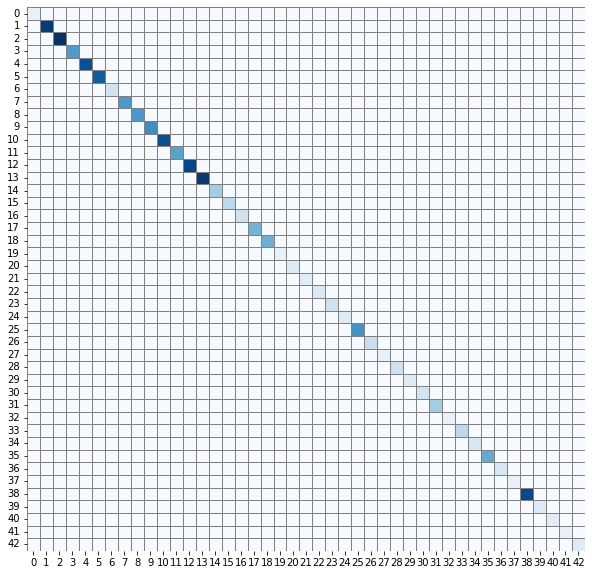

In [15]:
cm = tf.math.confusion_matrix(
    val_data.classes, preds_filtered, num_classes=43)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, cbar=False, cmap="Blues", linewidths=1, linecolor='grey')
ax.plot()
plt.show()

In [16]:
def predict_image(test_img):
    test_img = prepare_image(test_img)
    test_preds = model.predict(test_img)
    print("Class was identified as:", np.argmax(test_preds, axis=1)
        [0], "with confidence of:", int(100*(test_preds.max())),"%")
    print(label_map[(np.argmax(test_preds, axis=1))[0]])


test_images = ["kruhac.jpg", "zakazjednosmerka.jpg", "hlavni.jpeg"]

for image in test_images:
    image_path = os.path.join(SIGN_DIR,image)
    predict_image(image_path)

Class was identified as: 40 with confidence of: 95 %
turn_circle
Class was identified as: 17 with confidence of: 98 %
no_way_one_way
Class was identified as: 12 with confidence of: 95 %
right_of_way_general


In [17]:
model.save(OUT_MODEL)

In [18]:
# Convert the model to TF Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(OUT_LITE_MODEL, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\david\AppData\Local\Temp\tmpqp51fx3c\assets


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)
Accuracy of the shown eval batch:


1.0

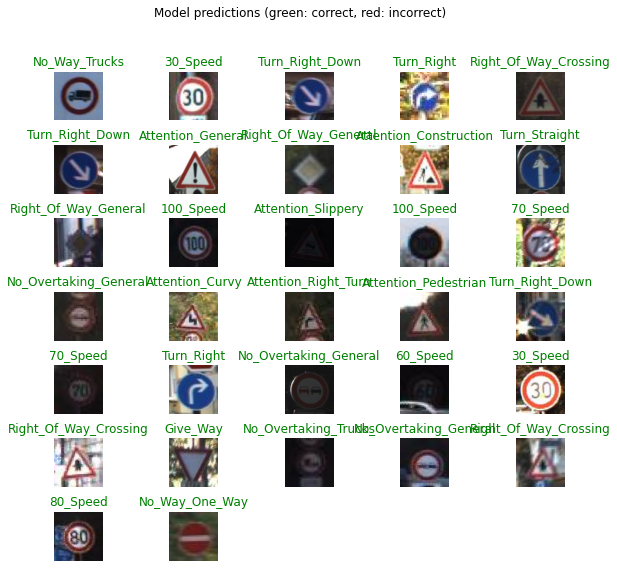

In [12]:
for image_val_batch, label_val_batch in val_data:
    print("Image batch shape: ", image_val_batch.shape)
    print("Label batch shape: ", label_val_batch.shape)
    break

predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + \
    (batch_size % num_plot_column > 0)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
    plt.subplot(num_plot_row, num_plot_column, n+1)
    plt.imshow(image_val_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(label_map[predicted_id[n]].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

print("Accuracy of the shown eval batch:")
sklearn.metrics.accuracy_score(label_id, predicted_id)

Accuracy of the shown eval batch, with the TensorFlow Lite model:


1.0

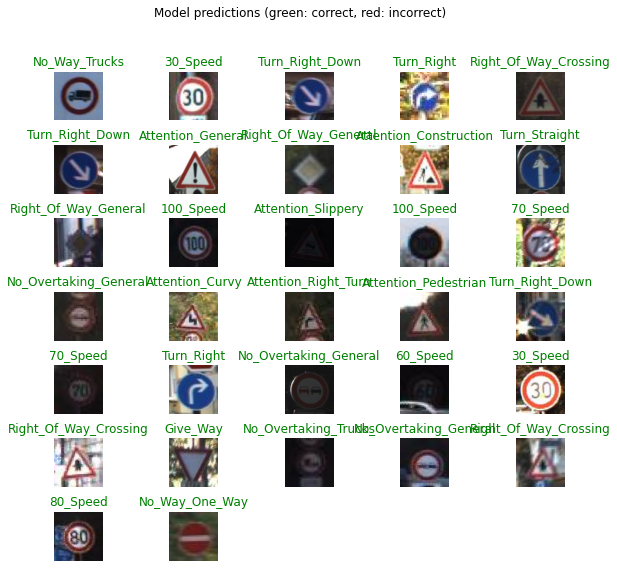

In [13]:
interpreter = tf.lite.Interpreter(model_path=OUT_LITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

batch_size = image_val_batch.shape[0]
predicted_id = np.zeros(batch_size)

for i, image in enumerate(np.split(image_val_batch, batch_size)):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  predicted_id[i] = np.argmax(output_data)

label_id = np.argmax(label_val_batch, axis=-1)

num_plot_column = 5
num_plot_row = batch_size // num_plot_column + \
    (batch_size % num_plot_column > 0)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row, num_plot_column, n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


print("Accuracy of the shown eval batch, with the TensorFlow Lite model:")
sklearn.metrics.accuracy_score(label_id, predicted_id)


In [26]:
from google.colab import files
files.download(OUT_MODEL)
files.download(OUT_LITE_MODEL)

In [28]:
!zip -r /content/logs.zip /content/logs
files.download("logs.zip")

  adding: content/logs/ (stored 0%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1648454055.ebdf6880f236.82.0.v2 (deflated 66%)
  adding: content/logs/train/events.out.tfevents.1648455182.ebdf6880f236.82.2.v2 (deflated 66%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1648455363.ebdf6880f236.82.3.v2 (deflated 77%)
  adding: content/logs/validation/events.out.tfevents.1648454108.ebdf6880f236.82.1.v2 (deflated 76%)
